In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
N7D4chi8 = pd.read_csv("data_N7_D4_chi8_seed13.csv")

In [3]:
import strawberryfields as sf
def new_basis(basis_params,Dout=17):
    integrals_mat = np.zeros((Dout,D),dtype=np.complex128)
    for n in range(D):
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.Fock(n) | q[0]
            sf.ops.Kgate(basis_params["kappa"]) | q[0]
            sf.ops.Vgate(basis_params["gamma"]) | q[0]
            sf.ops.Pgate(basis_params["s"]) | q[0]
            sf.ops.Rgate(basis_params["theta"]) | q[0]
            sf.ops.Sgate(basis_params["r"],basis_params["phi"]) | q[0]
            sf.ops.Dgate(np.abs(basis_params["alpha"]),np.angle(basis_params["alpha"])) | q[0]

        eng = sf.Engine("fock", backend_options={"cutoff_dim": Dout})
        result = eng.run(prog)
        integrals_mat[:,n] = result.state.ket()
    return integrals_mat

In [4]:
from tqdm import tqdm
import os
import json
D = 4
N = 7

folder_path = "./"
key = "basisparams_N7_D4_chi8"
filenames = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f[:len(key)] == key]

Douts = np.arange(D,300)
traces = np.zeros((len(filenames),N,len(Douts)))
for k, filename in enumerate(filenames):
    print("File #",k,"/",len(filenames))
    with open(os.path.join(folder_path,filename), "r") as file:
        basis_params2 = json.load(file)
        basis_params = {key: item[-1] for key, item in basis_params2.items()}
        basis_params["alpha"] = [x + 1j * y for x,y in zip(basis_params["alpha_real"],basis_params["alpha_imag"])]
    for i in tqdm(range(N)):
        # for j,Dout in enumerate(Douts):
        #     tmp = new_basis({key: basis_params[key][i] for key in basis_params.keys()},int(300))
        #     traces[k,i,j] = np.trace(tmp.T.conj()@tmp)/D
        #     if 1 - traces[k,i,j] < 1e-15:
        #         traces[k,i,j+1:] = 1
        #         break
        tmp = new_basis({key: basis_params[key][i] for key in basis_params.keys()},int(300))
        traces[k,i] = [np.trace(tmp[:i].T.conj()@tmp[:i])/D for i in range(D,300)]

File # 0 / 11


  0%|          | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_500516/1860631580.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


File # 1 / 11


100%|██████████| 7/7 [00:01<00:00,  4.81it/s]


File # 2 / 11


100%|██████████| 7/7 [00:01<00:00,  4.61it/s]


File # 3 / 11


100%|██████████| 7/7 [00:01<00:00,  4.92it/s]


File # 4 / 11


100%|██████████| 7/7 [00:01<00:00,  4.94it/s]


File # 5 / 11


100%|██████████| 7/7 [00:01<00:00,  4.33it/s]


File # 6 / 11


100%|██████████| 7/7 [00:01<00:00,  4.54it/s]


File # 7 / 11


100%|██████████| 7/7 [00:01<00:00,  4.93it/s]


File # 8 / 11


100%|██████████| 7/7 [00:01<00:00,  4.04it/s]


File # 9 / 11


100%|██████████| 7/7 [00:01<00:00,  4.26it/s]


File # 10 / 11


100%|██████████| 7/7 [00:01<00:00,  4.22it/s]


In [ ]:
specW = 1 - traces
effective_cutoff = np.array([Douts[1:][mask][0] for mask in (np.mean((specW[:,:,:-1] - specW[:,:,1:]),1) < 1e-16)])
##### Comment #####
# The np.mean(..., axis=1) is just because this specific system exhibits translational invariance so the basisparameters learned for each
# mode are the same. This is not the case in general and the effective_cutoff should be calculated for each mode separately.
###################

tmp_kappas = [float(f[len(key)+1:].split("_")[0][1:]) for f in filenames]
effective_cutoff = effective_cutoff[np.argsort(tmp_kappas)]

(0.0, 80.0)

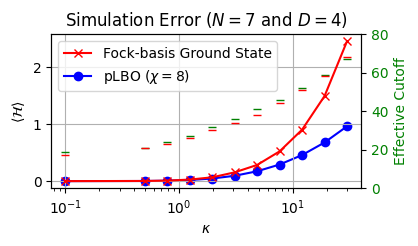

In [ ]:
fig, ax = plt.subplots(figsize=(4,2))
plt.grid()

ax.plot(N7D4chi8.current_ks, N7D4chi8.E_GS, color = "red",marker="x", label=r"Fock-basis Ground State")
ax.plot(N7D4chi8.current_ks, N7D4chi8.E_MPSs, color="blue",label=r"pLBO ($\chi = 8$)",zorder=-1,marker="o")

ax.set_xscale("log")
ax.set_ylabel(r"$\langle\mathcal{H}\rangle$")
ax.set_xlabel(r"$\kappa$")
ax.legend()
ax.set_title(r"Simulation Error ($N=7$ and $D=4$)")

ax2 = ax.twinx()
ax2.set_ylabel("Effective Cutoff", color="green")
ax2.tick_params(axis='y', labelcolor='green')
ax2.plot(np.sort(N7D4chi8.current_ks), effective_cutoff, color="green", marker="_", ls="None")
# ax2.plot(np.sort(N7D4chi8.current_ks), np.array([17, 21, 23, 26, 30, 34, 38, 44, 51, 58, 68]), color="red", marker="_", ls="None") #<-- values used in the initial preprint.

ax2.set_ylim(0,80)